In [43]:
from imageio import imread
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

C:\Users\sanfe\AppData\Local\Temp\ipykernel_12300\4039691274.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  terrain1 = imread('SRTM_data_Norway_1.tif')


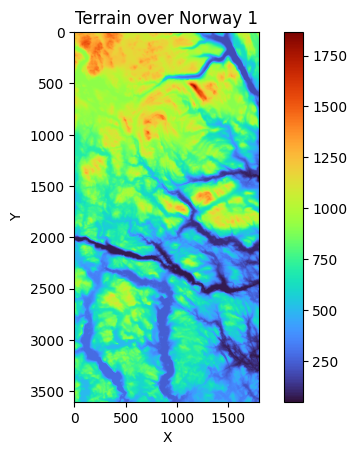

In [44]:
# Load the terrain
terrain1 = imread('SRTM_data_Norway_1.tif')

# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain1, cmap="turbo")
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()
plt.show()

In [45]:
terrain1.shape

(3601, 1801)

The dataset is a grid of dimension 3601x1801.

In [46]:
#create design matrix
def create_X(x, y, n ):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X

def MSE(y_data, y_model):
    n = np.size(y_model)
    return np.sum((y_data - y_model)**2)/n

def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

In [47]:
# Create a meshgrid of coordinates matching the shape of the terrain data
x = np.linspace(0, 1, terrain1.shape[1])
y = np.linspace(0, 1, terrain1.shape[0])
x, y = np.meshgrid(x, y)
#x = np.ravel(x)
#y = np.ravel(y)

z = terrain1#.ravel()

In [48]:
z

Array([[1161, 1165, 1169, ...,  931,  922,  922],
       [1168, 1171, 1174, ...,  941,  928,  922],
       [1172, 1173, 1176, ...,  945,  934,  924],
       ...,
       [ 673,  677,  681, ...,  300,  300,  297],
       [ 675,  677,  681, ...,  296,  297,  294],
       [ 677,  680,  682, ...,  292,  294,  292]], dtype=int16)

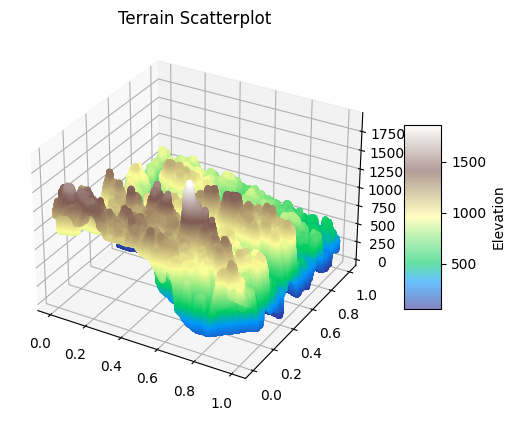

In [12]:
# Create a 3D scatter plot for the terrain data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Terrain Scatterplot')

# Flatten the arrays for the scatter plot
x_flat = x.flatten()
y_flat = y.flatten()
terrain_flat = terrain1.flatten()

# Create the scatter plot
sc = ax.scatter(x_flat, y_flat, terrain_flat, c=terrain_flat, cmap="terrain", s=10, alpha=0.6)

# Add a color bar which maps values to colors
cbar = fig.colorbar(sc, shrink=0.5, aspect=5)
cbar.set_label('Elevation')

plt.show()

**OLS**

In [61]:
degree = 5

x = x.reshape(-1,1) #reshaping the meshgrid in two arrays
y = y.reshape(-1,1)
z = z.reshape(-1,1)

X = create_X(x, y, degree)

# Removing the intercept column, we later calculate the model's intercept
X = X[:,1:]

# splitting in train and test data
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size = 0.2, random_state = 42)

In [62]:
# Scaling the data
X_train_mean = np.mean(X_train, axis=0)
X_train_scaled = X_train - X_train_mean
X_test_scaled = X_test - X_train_mean
z_scaler = np.mean(z_train)           
z_train_scaled = z_train - z_scaler
z_test_scaled = z_test - z_scaler

In [63]:
betaOLS = (np.linalg.inv(X_train_scaled.T @ X_train_scaled) @ X_train_scaled.T ) @ z_train_scaled
interceptOLS = z_scaler - X_train_mean @ betaOLS

# Make the prediction
ztildeOLS = X_train_scaled @ betaOLS + z_scaler
zpredictOLS = X_test_scaled @ betaOLS + z_scaler

#MSE and R2
print("MSE train OLS: ")
print(MSE(z_train, ztildeOLS))
print("R2 train OLS: ")
print(R2(z_train, ztildeOLS))
print("MSE test OLS: ")
print(MSE(z_test, zpredictOLS))
print("R2 test OLS: ")
print(R2(z_test, zpredictOLS))

MSE train OLS: 
42633.27124150441
R2 train OLS: 
0.5370545150576356
MSE test OLS: 
42553.765748458994
R2 test OLS: 
0.5383558723310004
